In [61]:
import pandas as pd
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer
import jieba.posseg as pseg
from wordcloud import WordCloud
import matplotlib.pyplot as plt


In [ ]:
# load data 
df = pd.read_csv("data/comments.csv")
df = df[~df['comment'].str.contains(r'^\{\{.*\}\}$', na=False)]
df = df.dropna(subset=['comment'])
df = df[df['comment'].str.strip() != '']

In [5]:
df.head()

,perfume_id,url,comment
2,161998,https://www.nosetime.com/161998-,苦橙，薰衣草，藏红花，看似平常的香料，却孕育了小清新眼中的梦魇。作为xerjoff的副牌，它...
3,161998,https://www.nosetime.com/161998-,3.5分今天同时上手试的有：米勒哈瑞斯·烟，迪拜精神·meydan这支用的是广藿香+藏红花制...
4,161998,https://www.nosetime.com/161998-,这款也是很神奇，刚上皮的时候很爱，深沉潮湿的乌木味道，然而越闻越不大对劲，为什么越来越酸啊，...
5,161998,https://www.nosetime.com/161998-,一开始就像弱化版的史诗男。后面出现的果香和脂类气息中和了苦大仇深的烟熏焚香，随时间推移气息接...
6,161998,https://www.nosetime.com/161998-,刚上身，特别harrods的味道，熏的我啊头晕，真的受不了！没曾想洗了澡之后，第二天睡醒，闻...


In [6]:
grouped = df.groupby('perfume_id')['comment'].apply(lambda x: ' '.join(x)).reset_index()

In [7]:
grouped.head()

,perfume_id,comment
0,100015,比玫瑰的那款好闻很多，甜丝丝的脂粉，这脂粉让这支香更像baby香水，而且还很温柔。虽然我仍然...
1,100158,冲着名字盲撸的，结果成了corday里我最喜欢的一支。西普和木质的底子，上面是有些类似比翼双...
2,100164,极具侵略性的猎奇新香……喷在手腕的一瞬间，其他任何味道就都闻不到了，全世界除了这个香，什么都...
3,100171,绝版很久买不到的小清新古董香，偶然收了个绿色版Samourai woman love aqu...
4,100193,让我闭眼闻，我被打死也想不到98的香水。质感肯定不是很好，这价格不要求高级，但是化工是不至于...


In [47]:
custom_stopwords = set([
    '我', '也', '很', '的', '这个', '那个', '我们', '你', '它', '他们',
    '香水', '味道', '香味', '一种', '使用', '感觉', '就是', '不会', '如果', '因为',
    '有点', '可能', '自己', '没有', '真的', '还是', '但是', '一下', '有些', '味', 
    '了','不','和','有','像','吧','买','知道','就','那么','越','带','再','在','才','着','撸的','撸','结果'
])

In [49]:
def filtered_jieba(text):
    return [
        word for word, flag in pseg.cut(text)
        if flag in ('n', 'a') and len(word.strip()) > 1 and word not in custom_stopwords
    ]

vectorizer = TfidfVectorizer(
    tokenizer=filtered_jieba,
    max_df=0.85,
    min_df=3,
    max_features=1000
)
tfidf_matrix = vectorizer.fit_transform(grouped['comment'])
feature_names = vectorizer.get_feature_names_out()

In [41]:
def top_keywords(matrix, index, feature_names, top_n=10):
    row = matrix[index].toarray().flatten()
    top_idx = row.argsort()[::-1][:top_n]
    return [(feature_names[i], round(row[i], 4)) for i in top_idx]



In [53]:
print(top_keywords(tfidf_matrix, 0, feature_names))

[('杏仁', 0.4416), ('糖果', 0.3572), ('甜蜜', 0.272), ('脂粉', 0.214), ('黄色', 0.2104), ('情绪', 0.2078), ('奶香', 0.1533), ('瓶子', 0.153), ('小时候', 0.1366), ('少女', 0.1324)]


In [54]:
# Word Cloud Visualization
def plot_tfidf_wordcloud(df, perfume_id, font_path=None, max_words=100):
    keywords = df[df['perfume_id'] == perfume_id]
    word_freq = dict(zip(keywords['keyword'], keywords['score']))
    wc = WordCloud(
        font_path=font_path,
        background_color='white',
        width=800,
        height=400,
        max_words=max_words
    ).generate_from_frequencies(word_freq)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Top Keywords for Perfume {perfume_id}", fontsize=16)
    plt.show()

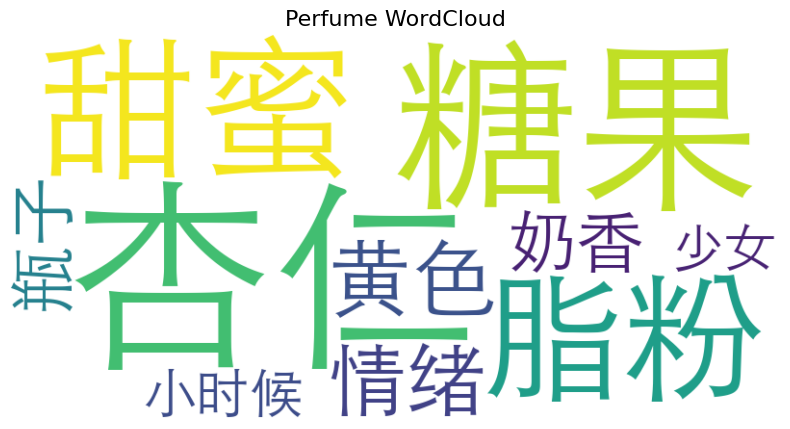

In [63]:
keywords = top_keywords(tfidf_matrix, 0, feature_names)
word_freq = dict(keywords)

wc = WordCloud(
    font_path = "/System/Library/Fonts/STHeiti Light.ttc",
    background_color='white',
    width=800,
    height=400
).generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Perfume WordCloud", fontsize=16)
plt.show()
